In [1]:
from numpy import *
import matplotlib.pyplot as plt
import operator
import time


In [4]:


def selectJrand(i, m):
    j = i
    while (j == i):
        j = int(random.uniform(0, m))
    return j

def clipAlpha(aj, H, L):
    if aj > H:
        aj = H
    if L > aj:
        aj = L
    return aj

class optStruct:
    def __init__(self, dataMatIn, classLabels, C, toler):
        self.X = dataMatIn
        self.labelMat = classLabels
        self.C = C
        self.tol = toler
        self.m = shape(dataMatIn)[0]
        self.alphas = mat(zeros((self.m, 1)))
        self.b = 0
        self.eCache = mat(zeros((self.m, 2)))

def calcEk(oS, k):
    fXk = float(multiply(oS.alphas, oS.labelMat).T * (oS.X * oS.X[k, :].T)) + oS.b
    Ek = fXk - float(oS.labelMat[k])
    return Ek

def selectJ(i, oS, Ei):
    maxK = -1
    maxDeltaE = 0
    Ej = 0
    oS.eCache[i] = [1, Ei]
    validEcacheList = nonzero(oS.eCache[:, 0].A)[0]
    if (len(validEcacheList)) > 1:
        for k in validEcacheList:
            if k == i:
                continue
            Ek = calcEk(oS, k)
            deltaE = abs(Ei - Ek)
            if (deltaE > maxDeltaE):
                maxK = k
                maxDeltaE = deltaE
                Ej = Ek
        return maxK, Ej
    else:
        j = selectJrand(i, oS.m)
        Ej = calcEk(oS, j)
    return j, Ej

def updateEk(oS, k):
    Ek = calcEk(oS, k)
    oS.eCache[k] = [1, Ek]

def innerL(i, oS):
    Ei = calcEk(oS, i)
    if ((oS.labelMat[i] * Ei < -oS.tol) and (oS.alphas[i] < oS.C)) or ((oS.labelMat[i] * Ei > oS.tol) and (oS.alphas[i] > 0)):
        j, Ej = selectJ(i, oS, Ei)
        alphaIold = oS.alphas[i].copy()
        alphaJold = oS.alphas[j].copy()
        if (oS.labelMat[i] != oS.labelMat[j]):
            L = max(0, oS.alphas[j] - oS.alphas[i])
            H = min(oS.C, oS.C + oS.alphas[j] - oS.alphas[i])
        else:
            L = max(0, oS.alphas[j] + oS.alphas[i] - oS.C)
            H = min(oS.C, oS.alphas[j] + oS.alphas[i])
        if (L == H):
            # print("L == H")
            return 0
        eta = 2.0 * oS.X[i, :] * oS.X[j, :].T - oS.X[i, :] * oS.X[i, :].T - oS.X[j, :] * oS.X[j, :].T
        if eta >= 0:
            # print("eta >= 0")
            return 0
        oS.alphas[j] -= oS.labelMat[j] * (Ei - Ej) / eta
        oS.alphas[j] = clipAlpha(oS.alphas[j], H, L)
        updateEk(oS, j)
        if (abs(oS.alphas[j] - alphaJold) < 0.00001):
            # print("j not moving enough")
            return 0
        oS.alphas[i] += oS.labelMat[j] * oS.labelMat[i] * (alphaJold - oS.alphas[j])
        updateEk(oS, i)
        b1 = oS.b - Ei - oS.labelMat[i] * (oS.alphas[i] - alphaIold) * oS.X[i, :] * oS.X[i, :].T - oS.labelMat[j] * (oS.alphas[j] - alphaJold) * oS.X[i, :] * oS.X[j, :].T
        b2 = oS.b - Ei - oS.labelMat[i] * (oS.alphas[i] - alphaIold) * oS.X[i, :] * oS.X[j, :].T - oS.labelMat[j] * (oS.alphas[j] - alphaJold) * oS.X[j, :] * oS.X[j, :].T
        if (0 < oS.alphas[i]) and (oS.C > oS.alphas[i]):
            oS.b = b1
        elif (0 < oS.alphas[j]) and (oS.C > oS.alphas[j]):
            oS.b = b2
        else:
            oS.b = (b1 + b2) / 2.0
        return 1
    else:
        return 0

def smoP(dataMatIn, classLabels, C, toler, maxIter, kTup=('lin', 0)):
    """
    ÊäÈë£ºÊý¾Ý¼¯, Àà±ð±êÇ©, ³£ÊýC, ÈÝ´íÂÊ, ×î´óÑ­»·´ÎÊý
    Êä³ö£ºÄ¿±êb, ²ÎÊýalphas
    """
    oS = optStruct(mat(dataMatIn), mat(classLabels).transpose(), C, toler)
    iterr = 0
    entireSet = True
    alphaPairsChanged = 0
    while (iterr < maxIter) and ((alphaPairsChanged > 0) or (entireSet)):
        alphaPairsChanged = 0
        if entireSet:
            for i in range(oS.m):
                alphaPairsChanged += innerL(i, oS)
            # print("fullSet, iter: %d i:%d, pairs changed %d" % (iterr, i, alphaPairsChanged))
            iterr += 1
        else:
            nonBoundIs = nonzero((oS.alphas.A > 0) * (oS.alphas.A < C))[0]
            for i in nonBoundIs:
                alphaPairsChanged += innerL(i, oS)
                # print("non-bound, iter: %d i:%d, pairs changed %d" % (iterr, i, alphaPairsChanged))
            iterr += 1
        if entireSet:
            entireSet = False
        elif (alphaPairsChanged == 0):
            entireSet = True
        # print("iteration number: %d" % iterr)
    return oS.b, oS.alphas

def calcWs(alphas, dataArr, classLabels):
    """
    ÊäÈë£ºalphas, Êý¾Ý¼¯, Àà±ð±êÇ©
    Êä³ö£ºÄ¿±êw
    """
    X = mat(dataArr)
    labelMat = mat(classLabels).transpose()
    m, n = shape(X)
    w = zeros((n, 1))
    for i in range(m):
        w += multiply(alphas[i] * labelMat[i], X[i, :].T)
    return w

def plotFeature(dataMat, labelMat, weights, b):
    dataArr = array(dataMat)
    n = shape(dataArr)[0]
    xcord1 = []; ycord1 = []
    xcord2 = []; ycord2 = []
    for i in range(n):
        if int(labelMat[i]) == 1:
            xcord1.append(dataArr[i, 0])
            ycord1.append(dataArr[i, 1])
        else:
            xcord2.append(dataArr[i, 0])
            ycord2.append(dataArr[i, 1])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(xcord1, ycord1, s=30, c='red', marker='s')
    ax.scatter(xcord2, ycord2, s=30, c='green')
    x = arange(2, 7.0, 0.1)
    y = (-b[0, 0] * x) - 10 / linalg.norm(weights)
    ax.plot(x, y)
    plt.xlabel('X1'); plt.ylabel('X2')
    plt.show()

def main():
    trainDataSet, trainLabel = loadDataSet('testSet.txt')
    b, alphas = smoP(trainDataSet, trainLabel, 0.6, 0.0001, 40)
    ws = calcWs(alphas, trainDataSet, trainLabel)
    print("ws = \n", ws)
    print("b = \n", b)
    plotFeature(trainDataSet, trainLabel, ws, b)

In [5]:
def loadDataSet(fileName):
    dataMat = []
    labelMat = []
    with open(fileName) as fr:
        for line in fr.readlines():
            lineArr = line.strip().split('    ')
            dataMat.append([float(lineArr[0]), float(lineArr[1])])
            labelMat.append(float(lineArr[2]))
    return dataMat, labelMat

trainDataSet, trainLabel = loadDataSet('testSet.txt')

In [16]:
trainDataSet

[[3.542485, 1.977398],
 [3.018896, 2.556416],
 [7.55151, -1.58003],
 [2.114999, -0.004466],
 [8.127113, 1.274372],
 [7.108772, -0.986906],
 [8.610639, 2.046708],
 [2.326297, 0.265213],
 [3.634009, 1.730537],
 [0.341367, -0.894998],
 [3.125951, 0.293251],
 [2.123252, -0.783563],
 [0.887835, -2.797792],
 [7.139979, -2.329896],
 [1.696414, -1.212496],
 [8.117032, 0.623493],
 [8.497162, -0.266649],
 [4.658191, 3.507396],
 [8.197181, 1.545132],
 [1.208047, 0.2131],
 [1.928486, -0.32187],
 [2.175808, -0.014527],
 [7.886608, 0.461755],
 [3.223038, -0.552392],
 [3.628502, 2.190585],
 [7.40786, -0.121961],
 [7.286357, 0.251077],
 [2.301095, -0.533988],
 [-0.232542, -0.54769],
 [3.457096, -0.082216],
 [3.023938, -0.057392],
 [8.015003, 0.885325],
 [8.991748, 0.923154],
 [7.916831, -1.781735],
 [7.616862, -0.217958],
 [2.450939, 0.744967],
 [7.270337, -2.507834],
 [1.749721, -0.961902],
 [1.803111, -0.176349],
 [8.804461, 3.044301],
 [1.231257, -0.568573],
 [2.074915, 1.41055],
 [-0.743036, -1.73

In [18]:
trainLabel

[-1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0]

In [ ]:
def smoP(dataMatIn, classLabels, C, toler, maxIter, kTup=('lin', 0)):
    """
    ÊäÈë£ºÊý¾Ý¼¯, Àà±ð±êÇ©, ³£ÊýC, ÈÝ´íÂÊ, ×î´óÑ­»·´ÎÊý
    Êä³ö£ºÄ¿±êb, ²ÎÊýalphas
    """


In [43]:
dataMatIn = trainDataSet
classLabels = trainLabel
C = 0.6
toler = 0.0001 
maxIter = 40
kTup=('lin', 0)


oS = optStruct(mat(dataMatIn), mat(classLabels).transpose(), C, toler)
iterr = 0
entireSet = True
alphaPairsChanged = 0

In [44]:
while (iterr < maxIter) and ((alphaPairsChanged > 0) or (entireSet)):
    alphaPairsChanged = 0
    if entireSet:
        for i in range(oS.m):
            alphaPairsChanged += innerL(i, oS)
        # print("fullSet, iter: %d i:%d, pairs changed %d" % (iterr, i, alphaPairsChanged))
        iterr += 1
    else:
        nonBoundIs = nonzero((oS.alphas.A > 0) * (oS.alphas.A < C))[0]
        for i in nonBoundIs:
            alphaPairsChanged += innerL(i, oS)
            # print("non-bound, iter: %d i:%d, pairs changed %d" % (iterr, i, alphaPairsChanged))
        iterr += 1
    if entireSet:
        entireSet = False
    elif (alphaPairsChanged == 0):
        entireSet = True
    # print("iteration number: %d" % iterr)
    
    break

In [51]:
i

99

In [50]:
oS.m

100

In [45]:
entireSet

False

In [46]:
alphaPairsChanged

6

In [47]:
i

99

In [48]:
nonBoundIs

NameError: name 'nonBoundIs' is not defined

In [ ]:
def calcEk(oS, k):
    fXk = float(multiply(oS.alphas, oS.labelMat).T * (oS.X * oS.X[k, :].T)) + oS.b
    Ek = fXk - float(oS.labelMat[k])
    return Ek

In [ ]:
def innerL(i, oS):
    Ei = calcEk(oS, i)
    if ((oS.labelMat[i] * Ei < -oS.tol) and (oS.alphas[i] < oS.C)) or ((oS.labelMat[i] * Ei > oS.tol) and (oS.alphas[i] > 0)):
        j, Ej = selectJ(i, oS, Ei)
        alphaIold = oS.alphas[i].copy()
        alphaJold = oS.alphas[j].copy()
        if (oS.labelMat[i] != oS.labelMat[j]):
            L = max(0, oS.alphas[j] - oS.alphas[i])
            H = min(oS.C, oS.C + oS.alphas[j] - oS.alphas[i])
        else:
            L = max(0, oS.alphas[j] + oS.alphas[i] - oS.C)
            H = min(oS.C, oS.alphas[j] + oS.alphas[i])
        if (L == H):
            # print("L == H")
            return 0
        eta = 2.0 * oS.X[i, :] * oS.X[j, :].T - oS.X[i, :] * oS.X[i, :].T - oS.X[j, :] * oS.X[j, :].T
        if eta >= 0:
            # print("eta >= 0")
            return 0
        oS.alphas[j] -= oS.labelMat[j] * (Ei - Ej) / eta
        oS.alphas[j] = clipAlpha(oS.alphas[j], H, L)
        updateEk(oS, j)
        if (abs(oS.alphas[j] - alphaJold) < 0.00001):
            # print("j not moving enough")
            return 0
        oS.alphas[i] += oS.labelMat[j] * oS.labelMat[i] * (alphaJold - oS.alphas[j])
        updateEk(oS, i)
        b1 = oS.b - Ei - oS.labelMat[i] * (oS.alphas[i] - alphaIold) * oS.X[i, :] * oS.X[i, :].T - oS.labelMat[j] * (oS.alphas[j] - alphaJold) * oS.X[i, :] * oS.X[j, :].T
        b2 = oS.b - Ei - oS.labelMat[i] * (oS.alphas[i] - alphaIold) * oS.X[i, :] * oS.X[j, :].T - oS.labelMat[j] * (oS.alphas[j] - alphaJold) * oS.X[j, :] * oS.X[j, :].T
        if (0 < oS.alphas[i]) and (oS.C > oS.alphas[i]):
            oS.b = b1
        elif (0 < oS.alphas[j]) and (oS.C > oS.alphas[j]):
            oS.b = b2
        else:
            oS.b = (b1 + b2) / 2.0
        return 1
    else:
        return 0

In [ ]:
class optStruct:
    def __init__(self, dataMatIn, classLabels, C, toler):
        self.X = dataMatIn
        self.labelMat = classLabels
        self.C = C
        self.tol = toler
        self.m = shape(dataMatIn)[0]
        self.alphas = mat(zeros((self.m, 1)))
        self.b = 0
        self.eCache = mat(zeros((self.m, 2)))

In [28]:
mat

<function numpy.asmatrix(data, dtype=None)>

In [27]:
shape(trainDataSet)

(100, 2)

In [33]:
# def smoP(dataMatIn, classLabels, C, toler, maxIter, kTup=('lin', 0)):
oS = optStruct(mat(trainDataSet), mat(trainLabel).transpose(), 0.6, 0.0001)

In [34]:
oS.m

100

In [35]:
oS.alphas

matrix([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
      

In [36]:
oS.eCache

matrix([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0

In [37]:
b, alphas = smoP(trainDataSet, trainLabel, 0.6, 0.0001, 40)

In [38]:
b

matrix([[-2.70721904]])

In [39]:
alphas

matrix([[0.12020075],
        [0.        ],
        [0.0709378 ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.0119673 ],
        [0.0119673 ],
        [0.        ],
        [0.        ],
        [0.01213881],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.02154579],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.02154579],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0

In [20]:
ws = calcWs(alphas, trainDataSet, trainLabel)

In [21]:
print("ws = \n", ws)

ws = 
 [[ 0.65307162]
 [-0.17196128]]


In [22]:
print("b = \n", b)

b = 
 [[-2.89901748]]


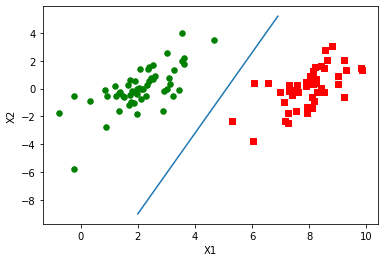

In [23]:
plotFeature(trainDataSet, trainLabel, ws, b)

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


ws = 
 [[ 0.65307162]
 [-0.17196128]]
b = 
 [[-2.89901748]]


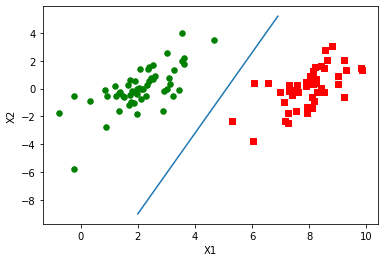

finish all in 209.89999999999998


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
start = time.clock()
main()
end = time.clock()
print('finish all in %s' % str(end - start))